# Iterative Closest Point

<img src="i/icp1.png" width=600>
<br>
<img src="i/icp2.png" width=600>
<br>

<img src="i/icp3.png" width=600>
<br>
<img src="i/icp4.png" width=600>


In [28]:
# generate 2 lidar scans (i.e. 2 point clouds A, B)
import numpy as np 
import matplotlib.pyplot as plt
from numpy.linalg import norm, svd

np.random.seed(1)
def generate_point_cloud(n=2, N=30):
    points = np.random.randn(n, N)
    return points 
A = generate_point_cloud()

def apply_rigid_transform(A, theta=5, t=[0.1, 0.15], noise_var=0.01):
    n, N = A.shape
    theta = np.deg2rad(theta)
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    t = np.array(t)
    B = R @ A + t.reshape(n, 1)
    B = B + np.random.normal(loc=0, scale=noise_var, size=B.shape)
    return B, R, t  

B, R, t = apply_rigid_transform(A)

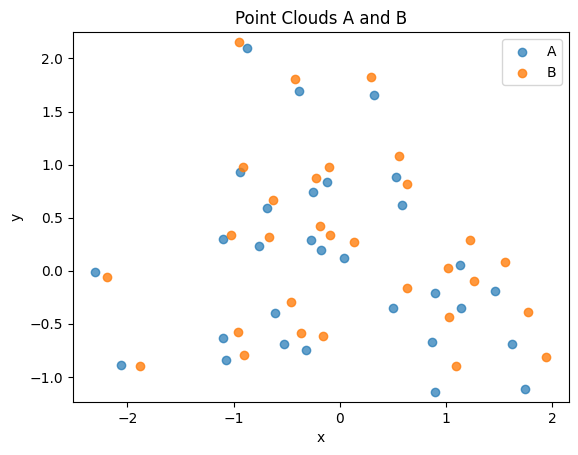

[[ 0.9961947  -0.08715574]
 [ 0.08715574  0.9961947 ]]
[0.1  0.15]


In [61]:
def plot_point_clouds(A, B, A_hat=None):
    plt.figure()
    plt.scatter(A[0, :], A[1, :], label="A", alpha=0.7)
    plt.scatter(B[0, :], B[1, :], label="B", alpha=0.8)
    if A_hat is not None: 
        plt.scatter(A_hat[0, :], A_hat[1, :], label="A_hat", alpha=0.7)
        
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.legend()
    plt.title("Point Clouds A and B")
    plt.show()

plot_point_clouds(A, B)
print(R)
print(t)

In [ ]:
# ICP find the motion function (R_hat, t_hat) that best matches 2 point clouds A and B
def best_fit_transform(A, B):
    Ac = A.mean(axis=1, keepdims=True)
    Bc = B.mean(axis=1, keepdims=True)

    A = A - Ac
    B = B - Bc 
    H = A @ B.T

    U, S, Vt = svd(H)
    R = Vt.T @ U.T 

    # fix if R is not a Rotation matrix (e.g R is a Reflection)
    if np.linalg.det(R) < 0: 
        Vt[-1, :] *= -1 
        R = Vt.T @ U.T 

    t = (Bc - R @ Ac).ravel()
    return R, t

R_hat, t_hat = best_fit_transform(A, B)
print(R_hat)
print(t_hat)

[[ 0.99626661 -0.0863298 ]
 [ 0.0863298   0.99626661]]
[0.10157799 0.1495762 ]


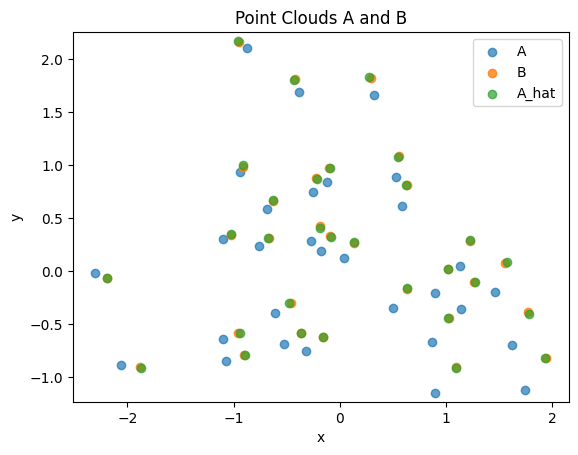

[[ 0.99626661 -0.0863298 ]
 [ 0.0863298   0.99626661]]
[0.10157799 0.1495762 ]


In [63]:
def icp(A, B, max_iters=50, tol=1e-6):
    A_hat = A.copy()
    R_hat = np.eye(2)
    t_hat = np.zeros(2)

    prev_error = np.inf 
    n, N = A.shape 

    for _ in range(max_iters):
        indices = []
        for i in range(N):
            dists = norm(B - A_hat[:, i:i+1], axis=0)
            j = np.argmin(dists)
            indices.append(j)
        
        B_matched = B[:, indices]

        R, t = best_fit_transform(A_hat, B_matched)

        A_hat = R @ A_hat + t[:, None]
        R_hat = R @ R_hat
        t_hat = R @ t_hat + t

        error = np.mean(norm(A_hat - B_matched, axis=0))
        if abs(prev_error - error) < tol:
            break

        prev_error = error
    return R_hat, t_hat, A_hat

R_hat, t_hat, A_hat = icp(A, B)
plot_point_clouds(A, B, A_hat)
print(R_hat)
print(t_hat)